In [1]:
# RNN for Deutsche Bank (DBK)
# Financial Industry

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import sklearn.preprocessing
import datetime
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tfc
tfc.disable_v2_behavior()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# read in the data
df = pd.read_csv("DBK.csv")
# order the dataset by date
df['Date'] = pd.to_datetime(df['Date'])
# show the head of the dataset
df.head()

,Mnemonic,Date,MaxPrice,MinPrice,StartPrice,EndPrice
0,DBK,2018-08-07,10.974,10.876,10.916,10.936
1,DBK,2018-08-08,10.944,10.764,10.886,10.776
2,DBK,2018-08-09,10.794,10.662,10.744,10.742
3,DBK,2018-01-16,15.398,15.166,15.244,15.206
4,DBK,2018-01-17,15.202,14.966,15.190,15.086


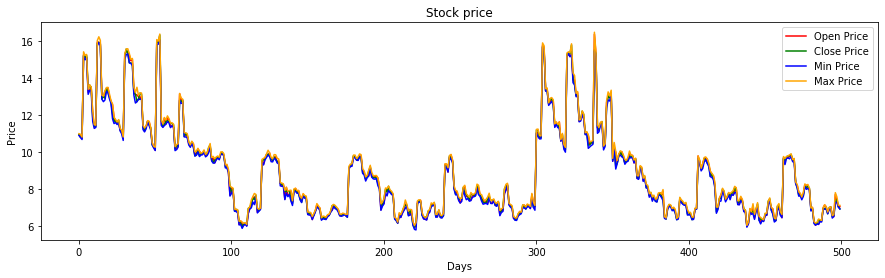

In [4]:
# Plot open, close, max, min prices of stocks
plt.figure(figsize=(15, 4));
plt.plot(df.StartPrice.values, color ='red', label ='Open Price')
plt.plot(df.EndPrice.values, color ='green', label='Close Price')
plt.plot(df.MinPrice.values, color ='blue', label = "Min Price")
plt.plot(df.MaxPrice.values, color ='orange', label ='Max Price')
plt.title('Stock price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')


In [5]:
# function to normalize the price
def normalize_stock_price(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['StartPrice'] = min_max_scaler.fit_transform(df["StartPrice"].values.reshape(-1,1))
    df['MaxPrice'] = min_max_scaler.fit_transform(df["MaxPrice"].values.reshape(-1,1))
    df['MinPrice'] = min_max_scaler.fit_transform(df["MinPrice"].values.reshape(-1,1))
    df['EndPrice'] = min_max_scaler.fit_transform(df['EndPrice'].values.reshape(-1,1))
    return df


# create train, test, validation sets
def split_sets(stock, seq_len):
    # change to array
    data_raw = stock.as_matrix() 
    # create empty data
    data = []
    
    # split Data
    valid_set_size = 0.1
    test_set_size = 0.1
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        # append data
        data.append(data_raw[index: index + seq_len])
    # change to numpy array
    data = np.array(data);
    
    valid_set_size = int(np.round(valid_set_size * data.shape[0]));  
    test_set_size = int(np.round(test_set_size * data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    # training set
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    # validation set
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    # test set
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


# drop cols that are not going to use in this model
df_stock = df.copy()
df_stock.drop(['Mnemonic'],1,inplace=True)
df_stock.drop(['Date'],1,inplace=True)


# normalize stock prices
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_stock_price(df_stock_norm)

# create train, test data
# chose sequence length
seq_len = 20 
x_train, y_train, x_valid, y_valid, x_test, y_test = split_sets(df_stock_norm, seq_len)


/Users/jingjie_ma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


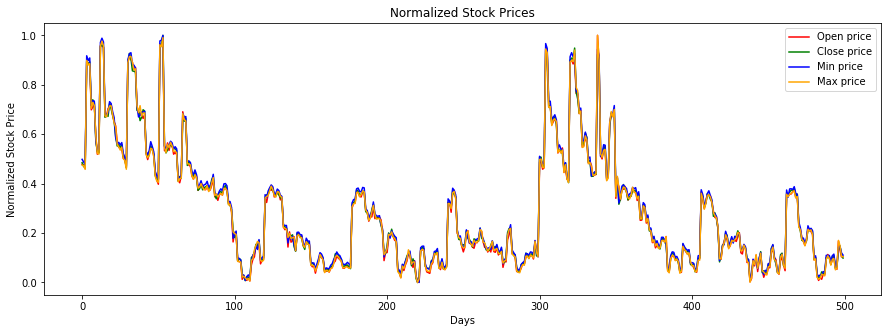

In [6]:
# plot normalized stock prices
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.StartPrice.values, color = 'red', label = 'Open price')
plt.plot(df_stock_norm.EndPrice.values, color = 'green', label = 'Close price')
plt.plot(df_stock_norm.MinPrice.values, color = 'blue', label = 'Min price')
plt.plot(df_stock_norm.MaxPrice.values, color = 'orange', label = 'Max price')

# add title and axes
plt.title('Normalized Stock Prices')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Price')
plt.legend(loc='best')
plt.show()

In [7]:
# use basic cell in tensorflow
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        # random shuffle
        np.random.shuffle(perm_array) 
        # start epoch
        start = 0 
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]


# define parameters for rnn
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 300 
n_outputs = 4
n_layers = 3
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]



ops.reset_default_graph()
# create placeholder
X = tfc.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tfc.placeholder(tf.float32, [None, n_outputs])

In [8]:
# disable the tf ver. 2 behavior to continue
tfc.disable_v2_behavior()

In [9]:
# use Basic RNN Cell
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]


Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [10]:
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [11]:
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 

In [13]:
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [14]:
# get output
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] 
                                              

In [15]:
# mean square error
mse = tf.reduce_mean(tf.square(outputs - y)) 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(mse)

In [16]:
# recurrent neural nets
with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = mse.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = mse.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE on training set/validation set = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
        y_train_pred = sess.run(outputs, feed_dict={X: x_train})
        y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
        y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE on training set/validation set = 0.783649/0.374013
4.95 epochs: MSE on training set/validation set = 0.099712/0.124933
9.90 epochs: MSE on training set/validation set = 0.027359/0.011868
14.84 epochs: MSE on training set/validation set = 0.015912/0.010890
19.79 epochs: MSE on training set/validation set = 0.013121/0.006632
24.74 epochs: MSE on training set/validation set = 0.020640/0.009056
29.69 epochs: MSE on training set/validation set = 0.015783/0.010982
34.64 epochs: MSE on training set/validation set = 0.010625/0.005705
39.58 epochs: MSE on training set/validation set = 0.009812/0.005202
44.53 epochs: MSE on training set/validation set = 0.009456/0.005202
49.48 epochs: MSE on training set/validation set = 0.008229/0.003832
54.43 epochs: MSE on training set/validation set = 0.009492/0.005795
59.38 epochs: MSE on training set/validation set = 0.009725/0.006328
64.32 epochs: MSE on training set/validation set = 0.008406/0.004822
69.27 epochs: MSE on training set/val

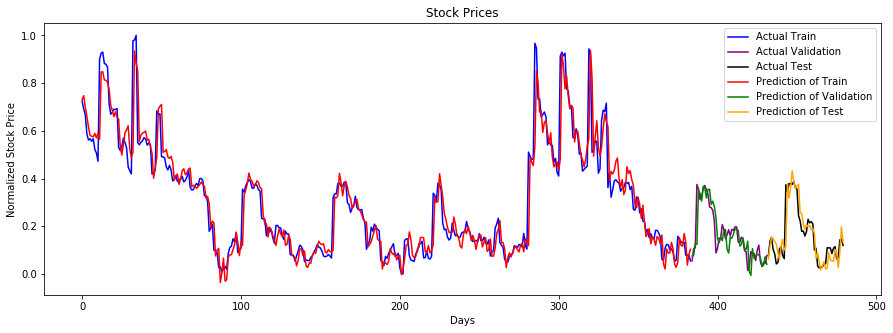

In [17]:
# choose close price
ft = 1 

## show predictions and actual values
plt.figure(figsize = (15, 5));


plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color = 'blue', label='Actual Train')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_valid.shape[0]), y_valid[:,ft],
         color='purple', label='Actual Validation')

plt.plot(np.arange(y_train.shape[0] + y_valid.shape[0],
                   y_train.shape[0] + y_test.shape[0] + y_test.shape[0]),
         y_test[:,ft], color = 'black', label = 'Actual Test')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='Prediction of Train')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color = 'green', label='Prediction of Validation')

plt.plot(np.arange(y_train_pred.shape[0] + y_valid_pred.shape[0],
                   y_train_pred.shape[0] + y_valid_pred.shape[0] + y_test_pred.shape[0]),
         y_test_pred[:,ft], color='orange', label='Prediction of Test')

plt.title('Stock Prices')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Price')
plt.legend(loc='best');
